<a href="https://colab.research.google.com/github/DrKenReid/Introductory-Data-Science/blob/main/Day_2_Lab_3_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks

To use GPU:

Go to `Runtime` in the top menu bar, select `Change runtime type`, and the select `T4 GPU`. This will significantly decrease the running time of model training.

# Problem/dataset Description:

For this hands-on exercise, we will work with the IMDB Reviews dataset and perform sentiment classification. We will use a simple RNN, LSTM, and GRU as our classification models. The task is to classify each movie review into one of two categories (positive or negative).

The steps involve: preprocessing the text data, feeding it into one of the neural network models, and training the model to predict the sentiment based on the textual content of the reviews.

### Explanation of the Dataset Installation and Q&A

1. **Q: What does `!pip install datasets` do?**
   - **A: It installs the `datasets` library, which is commonly used for accessing and managing a wide variety of datasets in machine learning.**

### Likely Student Questions and Answers

**Q: Why do we use `!pip install datasets` in the code?**
- **A: The exclamation mark `!` allows us to run shell commands from within a Jupyter notebook or other interactive Python environments. `pip install datasets` installs the `datasets` library, which provides easy access to many machine learning datasets.**

**Q: What is the `datasets` library used for?**
- **A: The `datasets` library, developed by Hugging Face, provides a collection of ready-to-use datasets for various machine learning tasks, along with tools for loading, processing, and manipulating them efficiently.**

**Q: Why might we prefer using the `datasets` library over other dataset libraries?**
- **A: The `datasets` library is designed for high performance, scalability, and ease of use. It supports a wide range of datasets, integrates well with popular ML frameworks like PyTorch and TensorFlow, and offers built-in functions for common data preprocessing tasks.**

**Q: Can I use `!pip install datasets` in any Python environment?**
- **A: Yes, you can use this command in any environment where `pip` is available, such as Jupyter notebooks, command-line interfaces, and some IDEs that support shell commands.**

**Q: What should I do if the installation of `datasets` fails?**
- **A: Ensure that you have an active internet connection and the correct permissions to install packages. If the issue persists, check for specific error messages and consult the `datasets` library documentation or community forums for troubleshooting tips.**

**Q: How do I verify that the `datasets` library has been installed correctly?**
- **A: You can verify the installation by importing the library in your Python environment with `import datasets`. If there are no errors, the installation was successful.**

**Q: Is it necessary to install the `datasets` library every time I run my code?**
- **A: No, once installed, the library remains available in your Python environment. You only need to install it again if you switch to a different environment or if the library is updated and you want to install the latest version.**


In [13]:
!pip install datasets

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import numpy as np

### Likely Student Questions and Answers

**Q: Why is the `MAX_LEN` set to 256 tokens?**
- **A: This value is chosen based on the typical length of the input data. It helps to ensure that the sequences are not too long, which could increase computation time and memory usage, while still capturing enough information for the model to learn effectively.**

**Q: What is the significance of setting the `BATCH_SIZE` to 16?**
- **A: A batch size of 16 is a trade-off between memory efficiency and training speed. Smaller batches can make the model update more frequently but may not fully utilize GPU capabilities, while larger batches can lead to more stable updates but require more memory.**

**Q: Why do we train the model for only 3 epochs?**
- **A: Training for 3 epochs is often a starting point to avoid overfitting and to quickly evaluate the model's performance. Depending on the results, you might increase or decrease the number of epochs.**

**Q: How does the `LEARNING_RATE` affect model training?**
- **A: The learning rate controls how much the model's weights are adjusted with respect to the loss gradient. A smaller learning rate can lead to more precise convergence but slower training, while a larger learning rate can speed up training but might overshoot the optimal solution.**

**Q: Why do we check for `cuda` availability with `torch.cuda.is_available()`?**
- **A: Checking for `cuda` availability ensures that the model can utilize a GPU if available, which significantly speeds up training and evaluation compared to using a CPU.**

**Q: How do we decide the appropriate `LEARNING_RATE` for a model?**
- **A: The appropriate learning rate is often found through experimentation and hyperparameter tuning. Techniques like learning rate schedules or adaptive learning rate methods (e.g., Adam optimizer) can also help in finding an effective learning rate.**

**Q: What if the sequences in my data are longer than `MAX_LEN`?**
- **A: Sequences longer than `MAX_LEN` will be truncated, which might lead to loss of information. If this is a concern, consider increasing `MAX_LEN` or using techniques like sequence padding and truncation to manage sequence lengths appropriately.**

**Q: Why is it beneficial to use a GPU for training neural networks?**
- **A: GPUs are designed for parallel processing, making them much faster than CPUs for the large-scale computations required in training neural networks. This results in quicker training times and the ability to handle larger datasets and models.**


In [15]:
MAX_LEN = 256  # Maximum length of tokens
BATCH_SIZE = 16  # Number of samples per batch
EPOCHS = 3  # Number of complete passes through the dataset
LEARNING_RATE = 1e-3  # Step size for updating model weights
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available, otherwise use CPU

# Data preparation

The IMDB dataset is a collection of movie reviews, each tagged with a sentiment label: positive or negative. We will do binary classification on this dataset.

For the purpose of illustrations in this lab, we are using a portion of the full IMDB dataset.

### Explanation of the IMDBDataset Class and Q&A

3. **Q: Why do we use `BertTokenizer.from_pretrained('bert-base-uncased')`?**
   - **A: To load the pretrained BERT tokenizer, which is used to convert text into tokens that BERT can understand.**

4. **Q: What does the `__len__` method do?**
   - **A: It returns the number of samples in the dataset, which is the length of the texts list.**

5. **Q: What is the purpose of the `__getitem__` method?**
   - **A: It retrieves a single sample from the dataset at the given index, tokenizes the text, and returns the tokenized input along with the attention mask and label.**

6. **Q: How is the text tokenized in the `__getitem__` method?**
   - **A: Using the `tokenizer.encode_plus` method, which tokenizes the text, adds special tokens, and returns token IDs, attention masks, and handles padding and truncation.**

7. **Q: What does `padding='max_length'` do in the `encode_plus` method?**
   - **A: It pads the token sequence to the maximum length specified by `MAX_LEN`.**

8. **Q: Why do we use `return_attention_mask=True` in `encode_plus`?**
   - **A: To generate an attention mask, which indicates which tokens are actual data and which are padding, helping the model to ignore the padding tokens.**

9. **Q: What is the significance of `return_tensors='pt'` in the tokenizer encoding?**
   - **A: It ensures that the tokenized output is returned as PyTorch tensors, suitable for input into a PyTorch model.**

10. **Q: Why do we flatten the `input_ids` and `attention_mask` tensors?**
    - **A: To convert them from a 2D tensor (batch size, sequence length) to a 1D tensor, as expected by the model.**

11. **Q: How is the label converted to a tensor?**
    - **A: Using `torch.tensor(label, dtype=torch.long)` to convert the label into a long tensor, suitable for loss calculation in PyTorch.**

### Likely Student Questions and Answers

**Q: Why do we need to create a custom dataset class like `IMDBDataset`?**
- **A: A custom dataset class allows us to preprocess and format the data specifically for our model, ensuring that each sample is correctly tokenized and ready for input into the BERT model.**

**Q: How does `BertTokenizer` help in preparing the text data?**
- **A: `BertTokenizer` converts raw text into token IDs that BERT can process, adds special tokens required by BERT, and creates attention masks, handling details that are crucial for the model to understand the input properly.**

**Q: What happens if the text length exceeds `MAX_LEN` during tokenization?**
- **A: If the text length exceeds `MAX_LEN`, it will be truncated to fit within the maximum length, ensuring that all inputs are of a consistent size.**

**Q: Why is padding important in tokenization?**
- **A: Padding ensures that all input sequences are of the same length, which is necessary for batch processing in neural networks. It also helps in efficiently utilizing computational resources by standardizing input dimensions.**

**Q: How do the attention masks benefit the model?**
- **A: Attention masks help the model distinguish between actual tokens and padding tokens, allowing it to focus on the meaningful parts of the input and ignore the padding.**

**Q: What should we do if we encounter an error with tokenization?**
- **A: Check the input text for any anomalies, ensure that the tokenizer is correctly loaded, and verify that the `MAX_LEN` parameter is appropriately set. Consulting the BERT tokenizer documentation for specific error messages can also help troubleshoot issues.**

**Q: Can we use a different pretrained tokenizer with this dataset class?**
- **A: Yes, you can use a different pretrained tokenizer by modifying the `BertTokenizer.from_pretrained` line to load the desired tokenizer, as long as it supports the same methods used in the class.**

**Q: Why do we use `torch.tensor(label, dtype=torch.long)` for the labels?**
- **A: Converting labels to long tensors ensures compatibility with PyTorch's loss functions, which typically expect target labels to be in this format for classification tasks.**

**Q: What is the impact of truncation on the model's performance?**
- **A: Truncation can lead to loss of information if important parts of the text are cut off. It's a trade-off between managing input size and preserving as much information as possible. Adjusting `MAX_LEN` based on the dataset can help mitigate this issue.**


In [16]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LEN,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

### Explanation of the Dataset Loading and DataLoader Creation Code and Q&A

1. **Q: What does `dataset = load_dataset("imdb")` do?**
   - **A: It loads the IMDB dataset using the `datasets` library, which includes train and test splits of movie reviews and their corresponding sentiment labels.**

2. **Q: Why do we use `dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.3)))`?**
   - **A: This code shuffles the training dataset and selects 30% of it to create a smaller, manageable dataset for training. The `seed=42` ensures reproducibility.**

3. **Q: What is the purpose of `train_test_split` in this context?**
   - **A: `train_test_split` splits the reduced dataset into training and testing sets, with 80% of the data used for training and 20% for testing.**

4. **Q: What does the `create_data_loader` function do?**
   - **A: It creates a data loader for the given texts and labels by instantiating the `IMDBDataset` class and returning a `DataLoader` object with the specified batch size.**

5. **Q: Why do we pass `num_workers=2` to the `DataLoader`?**
   - **A: It sets the number of subprocesses to use for data loading, which can speed up data loading by parallelizing it.**

6. **Q: How are the `train_data_loader` and `test_data_loader` created?**
   - **A: By calling the `create_data_loader` function with the training and testing texts and labels, and the specified batch size.**

### Likely Student Questions and Answers

**Q: Why do we shuffle the training dataset before selecting a subset?**
- **A: Shuffling ensures that the subset is representative of the entire dataset, reducing bias that could arise from the order of the data.**

**Q: What is the significance of using `seed=42` in the shuffle method?**
- **A: Setting a seed ensures that the shuffling is reproducible, meaning that the same subset will be selected each time the code is run.**

**Q: Why do we only use 30% of the original training dataset?**
- **A: Using a smaller subset of the dataset can make training faster and more manageable, especially when experimenting with model architectures or hyperparameters.**

**Q: What does `test_size=0.2` mean in the `train_test_split` function?**
- **A: It specifies that 20% of the reduced dataset will be used as the test set, while the remaining 80% will be used for training.**

**Q: How does the `create_data_loader` function benefit the training process?**
- **A: It encapsulates the creation of the dataset and data loader into a reusable function, ensuring consistent data loading and preprocessing.**

**Q: Why do we need data loaders in PyTorch?**
- **A: Data loaders handle the batching, shuffling, and loading of data in parallel, which is essential for efficient training and evaluation of models.**

**Q: What happens if we increase the `batch_size` in the data loader?**
- **A: Increasing the batch size means that more samples will be processed at once, which can speed up training but also requires more memory. There's a trade-off between training speed and memory usage.**

**Q: Why is `num_workers` set to 2, and can we change it?**
- **A: `num_workers=2` means that two subprocesses will be used for data loading, which can speed up the process. This number can be adjusted based on the available CPU resources and the specific dataset. More workers can further speed up data loading but also use more CPU resources.**

**Q: How do we handle potential imbalances in the dataset after shuffling and splitting?**
- **A: Ensuring that the split is stratified (maintaining the proportion of labels) can help. Techniques like oversampling or undersampling can also be used to address any imbalances.**

**Q: Can we use a different dataset with the same `create_data_loader` function?**
- **A: Yes, as long as the dataset is in a format compatible with the `IMDBDataset` class, the `create_data_loader` function can be used to create data loaders for any text classification dataset.**
```

In [17]:
# Load dataset
dataset = load_dataset("imdb")
reduced_dataset = dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.3)))

# Split the reduced dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    reduced_dataset['text'], reduced_dataset['label'], test_size=0.2, random_state=42)

# Data Loaders
def create_data_loader(texts, labels, batch_size):
    ds = IMDBDataset(texts, labels)
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

# Create data loaders
train_data_loader = create_data_loader(train_texts, train_labels, BATCH_SIZE)
test_data_loader = create_data_loader(test_texts, test_labels, BATCH_SIZE)


# Setting up the models

We will use: RNN (Recurrent Neural Network), LSTM (Long Short-Term Memory), and GRU (Gated Recurrent Units) to do sentiment analysis on the IMDB movie reviews dataset.

### Explanation of the TextClassifier Class and Q&A

1. **Q: What is the purpose of the `TextClassifier` class?**
   - **A: The `TextClassifier` class is a neural network model for text classification, supporting RNN, LSTM, and GRU architectures.**

2. **Q: What does the `__init__` method do?**
   - **A: It initializes the model, including an embedding layer, a recurrent layer (RNN, LSTM, or GRU based on the `model_type`), and a fully connected layer.**

3. **Q: Why is `nn.Embedding(30522, 256)` used?**
   - **A: It creates an embedding layer with a vocabulary size of 30522 (BERT's vocab size) and an embedding dimension of 256, converting token IDs into dense vectors.**

4. **Q: How does the `model_type` parameter affect the model?**
   - **A: It determines which type of recurrent layer (RNN, LSTM, or GRU) is used in the model.**

5. **Q: What are the dimensions of the input and hidden states in the recurrent layers?**
   - **A: The input dimension is 256 (embedding size), and the hidden state dimension is 128.**

6. **Q: What does the `forward` method do?**
   - **A: It defines the forward pass of the model, embedding the input IDs, passing them through the recurrent layer, and then through a fully connected layer to produce the output.**

7. **Q: Why is `batch_first=True` used in the recurrent layers?**
   - **A: It indicates that the input and output tensors are expected to have the batch size as the first dimension, making the data format (batch_size, sequence_length, features).**

8. **Q: How is the output of the recurrent layer processed in the forward method?**
   - **A: The output of the recurrent layer is processed by taking the hidden state (for LSTM, the hidden state from the tuple), squeezing it to remove unnecessary dimensions, and passing it through the fully connected layer.**

### Likely Student Questions and Answers

**Q: What is the role of the embedding layer in the model?**
- **A: The embedding layer converts input token IDs into dense vectors of a specified size (256 in this case), capturing semantic information about the tokens.**

**Q: How does the model handle different types of recurrent layers?**
- **A: The model uses an `if-elif` structure to initialize either an RNN, LSTM, or GRU layer based on the `model_type` parameter passed during initialization.**

**Q: What happens if an unsupported `model_type` is passed to the `TextClassifier`?**
- **A: The current implementation does not handle unsupported `model_type` values explicitly, which could lead to an error. It's good practice to add error handling for invalid `model_type` values.**

**Q: Why do we check if `hidden` is a tuple in the forward method?**
- **A: LSTM layers return a tuple (hidden state, cell state), while RNN and GRU return just the hidden state. The check ensures the correct hidden state is used for further processing.**

**Q: What is the significance of `hidden.squeeze(0)` in the forward method?**
- **A: `squeeze(0)` removes the first dimension if it is 1, effectively reshaping the hidden state tensor to the correct size for input to the fully connected layer.**

**Q: How does the model handle variable-length sequences?**
- **A: The current implementation assumes fixed-length sequences based on padding. For variable-length sequences, additional handling (like packing padded sequences) would be needed.**

**Q: Why do we need a fully connected layer at the end of the model?**
- **A: The fully connected layer maps the final hidden state to the output space, producing logits for the classification task (2 classes in this case).**

**Q: Can this model be used for multi-class classification tasks?**
- **A: Yes, the model can be adapted for multi-class classification by changing the output dimension of the fully connected layer to the number of classes.**

**Q: How does the choice of RNN, LSTM, or GRU affect the model's performance?**
- **A: RNNs are simpler but can struggle with long-term dependencies. LSTMs and GRUs are more complex and better at capturing long-term dependencies, often leading to better performance on sequential data tasks.**

**Q: What adjustments are needed if we want to use a different pre-trained tokenizer?**
- **A: Ensure the vocabulary size in the embedding layer matches the new tokenizer's vocabulary size. Also, make sure the tokenization and preprocessing steps are compatible with the new tokenizer.**
```

Recurrent Neural Networks (RNNs), Long Short-Term Memory (LSTM) networks, and Gated Recurrent Units (GRUs) are all types of recurrent neural networks designed to handle sequential data. Here are the key differences between them:

### Recurrent Neural Networks (RNNs)

- **Structure**: RNNs have a simple structure where the output from the previous step is fed as input to the current step. This creates a loop that allows information to persist.
- **Vanishing Gradient Problem**: RNNs often suffer from the vanishing gradient problem, making it difficult to learn long-term dependencies. This happens because the gradients used during backpropagation can become very small, effectively stopping the learning process for earlier layers in long sequences.
- **Use Case**: Suitable for simple sequence data where long-term dependencies are not critical.

### Long Short-Term Memory (LSTM) Networks

- **Structure**: LSTMs have a more complex structure, including a cell state and three gates (input gate, forget gate, and output gate). These gates regulate the flow of information into and out of the cell state, allowing the network to maintain and update long-term dependencies.
- **Forget Gate**: Decides which information to discard from the cell state.
- **Input Gate**: Decides which information to update in the cell state.
- **Output Gate**: Decides the output based on the cell state and the input.
- **Ability to Handle Long-Term Dependencies**: LSTMs are designed to remember information for long periods, effectively addressing the vanishing gradient problem.
- **Use Case**: Suitable for tasks that require learning and maintaining long-term dependencies, such as language modeling, translation, and time series prediction.

### Gated Recurrent Units (GRUs)

- **Structure**: GRUs are similar to LSTMs but have a simpler architecture. They consist of two gates: a reset gate and an update gate.
- **Reset Gate**: Determines how much of the past information to forget.
- **Update Gate**: Decides how much of the past information to carry forward to the future.
- **Fewer Parameters**: GRUs have fewer parameters compared to LSTMs, making them computationally more efficient while still being able to handle long-term dependencies.
- **Ability to Handle Long-Term Dependencies**: GRUs, like LSTMs, address the vanishing gradient problem and can handle long-term dependencies, though with a simpler mechanism.
- **Use Case**: Suitable for tasks that require maintaining long-term dependencies with a preference for computational efficiency, such as real-time processing tasks and cases where a faster model is needed.

### Summary

- **RNNs**: Simple structure, suffers from vanishing gradient problem, suitable for short-term dependencies.
- **LSTMs**: Complex structure with three gates, handles long-term dependencies well, computationally intensive.
- **GRUs**: Simplified version of LSTMs with two gates, handles long-term dependencies efficiently, fewer parameters and faster training compared to LSTMs.

Each type of network has its strengths and is chosen based on the specific requirements of the task at hand.

This code defines a neural network model for text classification using different types of recurrent neural networks (RNN, LSTM, GRU). The `TextClassifier` class is initialized with a specific model type ('rnn', 'lstm', or 'gru'), which determines the type of RNN used. An embedding layer converts input tokens into dense vectors, which are then processed by the chosen RNN to capture sequential information. The final hidden state from the RNN is passed through a fully connected layer to produce the output, which in this case is a binary classification. The `forward` method defines the forward pass of the model, handling the input data and returning the classification result.

In [18]:
# Neural Network Model with RNN, LSTM, and GRU
class TextClassifier(nn.Module):
    def __init__(self, model_type):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(30522, 256)  # Bert vocab size is 30522
        if model_type == 'rnn':
            self.rnn = nn.RNN(256, 128, batch_first=True)
        elif model_type == 'lstm':
            self.rnn = nn.LSTM(256, 128, batch_first=True)
        elif model_type == 'gru':
            self.rnn = nn.GRU(256, 128, batch_first=True)
        self.fc = nn.Linear(128, 2)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        output, hidden = self.rnn(x)
        if isinstance(hidden, tuple):  # LSTM returns (hidden, cell)
            hidden = hidden[0]
        hidden = hidden.squeeze(0)
        out = self.fc(hidden)
        return out

We could play with the following aspects of the model setup:

`embedding` defines the embedding layer, with 2 parameters: (1) the size of the input dimension (i.e, the BERT vocabulary size). This means the layer can represent each of the 30,522 unique tokens. Generally speaking, a larger number of dimensions can capture more complex features, with costs of computational resources and risks of overfitting; and (2) size of each embedding vector. In our current setup, each token from the vocabulary mentioned above is mapped to a 256-dimensional vector that represents learned features of that token.



RNN/LSTM/GRU Layers:

Parameters of these layers are: (1), number of expected features in the input; (2), the number of features that the model is expecte to capture. This parameter determines the model's ability to learn  complex patterns. (3), batch_first. This parameter affects the data structure or format that we give to layers.  RNN, LSTM, and GRU layers expects `atch_first=False`, but other layers expects True. batch_first=True gives more intuitive data format and makes data format compatible when integrating RNN, LSTM, and GRU outputs with other components like fully connected layers.


# Model training and evaluation

### Explanation of the Training and Evaluation Functions and Q&A

1. **Q: What is the purpose of the `train_epoch` function?**
   - **A: The `train_epoch` function trains the model for one epoch, updating the model's parameters and calculating the accuracy and average loss for the training data.**

2. **Q: Why do we use `model.train()` at the beginning of the `train_epoch` function?**
   - **A: It sets the model to training mode, enabling behaviors like dropout and batch normalization which are only active during training.**

3. **Q: What does `input_ids = d['input_ids'].to(device)` do?**
   - **A: It moves the input IDs to the specified device (GPU or CPU) for computation.**

4. **Q: How is the loss calculated in the `train_epoch` function?**
   - **A: The loss is calculated using the provided loss function (`loss_fn`) by comparing the model's outputs with the true labels.**

5. **Q: Why do we call `optimizer.zero_grad()` before `loss.backward()`?**
   - **A: To clear any accumulated gradients from previous iterations, ensuring that the gradients are correctly calculated for the current batch.**

6. **Q: What is the purpose of `loss.backward()` and `optimizer.step()`?**
   - **A: `loss.backward()` computes the gradients of the loss with respect to the model's parameters, and `optimizer.step()` updates the parameters based on these gradients.**

7. **Q: How is accuracy calculated in the `train_epoch` function?**
   - **A: Accuracy is calculated by summing the correct predictions and dividing by the total number of samples in the dataset.**

8. **Q: What does the `eval_model` function do?**
   - **A: The `eval_model` function evaluates the model's performance on the validation or test data, returning the accuracy and average loss without updating the model's parameters.**

9. **Q: Why do we use `model.eval()` at the beginning of the `eval_model` function?**
   - **A: It sets the model to evaluation mode, disabling behaviors like dropout and batch normalization that are only used during training.**

10. **Q: Why is `torch.no_grad()` used in the `eval_model` function?**
    - **A: It disables gradient calculation, reducing memory usage and speeding up computations during evaluation.**

11. **Q: How is the average loss calculated in both functions?**
    - **A: The average loss is calculated by taking the mean of the losses recorded for each batch.**

### Likely Student Questions and Answers

**Q: Why do we need separate functions for training and evaluation?**
- **A: Training and evaluation require different behaviors. Training involves updating the model's parameters using backpropagation, while evaluation only assesses the model's performance on validation or test data without updating the parameters.**

**Q: What is the role of the `optimizer` in the `train_epoch` function?**
- **A: The optimizer updates the model's parameters based on the gradients calculated during backpropagation, helping the model to minimize the loss function.**

**Q: How do we ensure that the model's parameters are not updated during evaluation?**
- **A: By setting the model to evaluation mode with `model.eval()` and using `torch.no_grad()` to disable gradient calculations.**

**Q: Why do we calculate the mean of the losses?**
- **A: Calculating the mean of the losses provides a single value that summarizes the model's performance across all batches, making it easier to monitor training progress.**

**Q: What does `correct_predictions.double() / len(data_loader.dataset)` compute?**
- **A: It computes the accuracy of the model by dividing the number of correct predictions by the total number of samples in the dataset.**

**Q: Can we modify these functions to support other types of models?**
- **A: Yes, these functions can be adapted to other types of models by ensuring the forward pass and loss calculation are compatible with the new model.**

**Q: What happens if `optimizer.zero_grad()` is not called?**
- **A: Gradients would accumulate from previous batches, leading to incorrect gradient calculations and potentially destabilizing the training process.**

**Q: Why is it important to set the model to evaluation mode during evaluation?**
- **A: Setting the model to evaluation mode ensures that layers like dropout and batch normalization behave correctly, providing accurate assessment of the model's performance.**

**Q: How can we track the training progress over multiple epochs?**
- **A: By storing the accuracy and loss values returned by `train_epoch` and `eval_model` for each epoch, and then plotting or printing these values to monitor the training progress.**

**Q: What if the model's performance is worse on the validation set than on the training set?**
- **A: This could indicate overfitting, where the model performs well on training data but poorly on unseen data. Regularization techniques, more data, or a simpler model might help address this issue.**
```

In [19]:
# Training function
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# Evaluate function
def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

Now, we train the models and get a look at the accuracy along with other evaluation metrics on test data.

The following code should take ~7 min to run

### Explanation of the Training and Evaluation Loop and Q&A

1. **Q: What is the purpose of the `model_types` list?**
   - **A: It contains the different types of models (`rnn`, `lstm`, `gru`) that will be trained and evaluated.**

2. **Q: Why do we use a loop to iterate over `model_types`?**
   - **A: To train and evaluate each model type (`rnn`, `lstm`, `gru`) sequentially, allowing comparison of their performance.**

3. **Q: What does `model = TextClassifier(model_type).to(DEVICE)` do?**
   - **A: It initializes a `TextClassifier` model of the specified type and moves it to the specified device (GPU or CPU).**

4. **Q: What is the role of `nn.CrossEntropyLoss().to(DEVICE)` in the code?**
   - **A: It defines the loss function used for training, and moves it to the specified device.**

5. **Q: How is the optimizer defined for the model?**
   - **A: The optimizer is defined using `torch.optim.Adam` with the model's parameters and a specified learning rate.**

6. **Q: What happens inside the training loop for each epoch?**
   - **A: The model is trained for one epoch using the `train_epoch` function, and the training loss and accuracy are printed.**

7. **Q: Why do we set `model.eval()` before evaluation?**
   - **A: To set the model to evaluation mode, disabling behaviors like dropout and batch normalization that are only used during training.**

8. **Q: How are the final outputs and targets collected for evaluation?**
   - **A: They are collected by iterating over the test data loader, making predictions, and storing the predicted and true labels.**

9. **Q: What metrics are calculated for model evaluation?**
   - **A: Accuracy, precision, recall, F1-score, and loss are calculated to evaluate the model's performance.**

10. **Q: Why do we use `torch.no_grad()` during evaluation?**
    - **A: To disable gradient calculation, reducing memory usage and speeding up computations during evaluation.**

11. **Q: How are the evaluation results stored and printed?**
    - **A: The results for each model type are stored in a dictionary and printed after evaluation.

### Likely Student Questions and Answers

**Q: Why do we train and evaluate multiple types of models (RNN, LSTM, GRU)?**
- **A: Training and evaluating multiple model types allows us to compare their performance and choose the best one for the specific task.**

**Q: What is the significance of moving the model and loss function to the specified device?**
- **A: Moving the model and loss function to the device ensures that computations are performed on the GPU if available, which speeds up training and evaluation.**

**Q: Why do we use `torch.optim.Adam` as the optimizer?**
- **A: Adam is a popular optimization algorithm that adjusts the learning rate dynamically based on the gradients, often leading to faster convergence compared to simpler optimizers like SGD.**

**Q: How is the training accuracy and loss calculated during each epoch?**
- **A: The training accuracy and loss are calculated by the `train_epoch` function, which processes the entire training dataset and returns the average loss and accuracy.**

**Q: Why is it important to evaluate the model on a separate test set?**
- **A: Evaluating on a separate test set provides an unbiased estimate of the model's performance on unseen data, helping to detect overfitting and assess generalization.**

**Q: How do we ensure the evaluation is performed correctly without updating the model's parameters?**
- **A: By setting the model to evaluation mode with `model.eval()` and using `torch.no_grad()` to disable gradient computations during evaluation.**

**Q: What is the purpose of calculating precision, recall, and F1-score in addition to accuracy?**
- **A: Precision, recall, and F1-score provide more detailed insights into the model's performance, especially in cases of imbalanced classes where accuracy alone may be misleading.**

**Q: How do we calculate the average loss during evaluation?**
- **A: The average loss is calculated by taking the mean of the losses for each batch in the test data loader.**

**Q: Why do we print the results for each model type after evaluation?**
- **A: Printing the results allows us to compare the performance of different model types and determine which one performs best for the task.**

**Q: What should we do if the model's performance is not satisfactory?**
- **A: Consider tuning hyperparameters (learning rate, batch size, etc.), using a different model architecture, increasing the training data, or improving data preprocessing.**

**Q: How can we handle the scenario where the dataset is imbalanced?**
- **A: Techniques like oversampling minority classes, undersampling majority classes, using weighted loss functions, or data augmentation can help address class imbalance.**


{'rnn': (0.5053333333333333, 0.7139620933126896), 'lstm': (0.6433333333333333, 0.809315027391657), 'gru': (0.722, 0.6452926746074189)}


The basic RNN model has the lowest accuracy among the three, and has a relatively high loss. The model might be underfitting.

LSTM models perform better than basic RNNs, as they can keep track of important information throughout the movie reviews. This is particularly important for long reviews, as the information at the beginning of the review might make sense by considering the full review together. LSTM that retains memory when analyzing such data has a higher accuracy.

GRUs is best among the three. Similar to LSTM, GRU can account for memory and can help avoid overfit.

In [20]:
from torch.utils.data import DataLoader
import numpy as np
import torch
import torch.nn as nn
from tabulate import tabulate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model_types = ['rnn', 'lstm', 'gru']
results = {}
for model_type in model_types:
    print(f"Training and evaluating model: {model_type.upper()}")
    model = TextClassifier(model_type).to(DEVICE)
    loss_fn = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        train_acc, train_loss = train_epoch(
            model, train_data_loader, loss_fn, optimizer, DEVICE)
        print(f'Train loss {train_loss} accuracy {train_acc}')

    # Evaluation
    model.eval()
    final_outputs = []
    final_targets = []
    with torch.no_grad():
        for d in test_data_loader:
            input_ids = d['input_ids'].to(DEVICE)
            attention_mask = d['attention_mask'].to(DEVICE)
            labels = d['labels'].to(DEVICE)
            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            final_outputs.extend(preds.cpu().numpy())
            final_targets.extend(labels.cpu().numpy())

    test_acc = accuracy_score(final_targets, final_outputs)
    precision, recall, f1, _ = precision_recall_fscore_support(final_targets, final_outputs, average='binary')
    test_loss = np.mean([
        loss_fn(
            model(d['input_ids'].clone().detach().to(DEVICE), d['attention_mask'].clone().detach().to(DEVICE)),
            d['labels'].clone().detach().to(DEVICE)  # Ensure labels are on the same device as the model
        ).item()
        for d in test_data_loader
    ])


    results[model_type] = {
        'accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'loss': test_loss
    }
    print(f"Results for {model_type.upper()}: Accuracy: {test_acc}, Precision: {precision}, Recall: {recall}, F1-score: {f1}, Loss: {test_loss}")


def format_results(results):
    # Prepare the data for tabulation
    data = []
    for model_type, metrics in results.items():
        row = [model_type.upper()] + [metrics[m] for m in ['accuracy', 'precision', 'recall', 'f1_score', 'loss']]
        data.append(row)

    # Define headers
    headers = ["Model", "Accuracy", "Precision", "Recall", "F1-score", "Loss"]

    # Create the table
    table = tabulate(data, headers=headers, tablefmt="grid", floatfmt=".4f")

    return table

# Assuming 'results' is the dictionary returned by your code
print("RNN Models Comparison Results")
print(format_results(results))

Training and evaluating model: RNN
Epoch 1/3
Train loss 0.7048776529630025 accuracy 0.5071666666666667
Epoch 2/3
Train loss 0.6862995425860087 accuracy 0.5365
Epoch 3/3
Train loss 0.6419523843924204 accuracy 0.5875
Results for RNN: Accuracy: 0.5026666666666667, Precision: 0.5187165775401069, Recall: 0.25526315789473686, F1-score: 0.3421516754850088, Loss: 0.7325109674575481
Training and evaluating model: LSTM
Epoch 1/3
Train loss 0.6961345068613688 accuracy 0.5151666666666667
Epoch 2/3
Train loss 0.6680211482048035 accuracy 0.5678333333333333
Epoch 3/3
Train loss 0.565173053264618 accuracy 0.6425
Results for LSTM: Accuracy: 0.5413333333333333, Precision: 0.6104294478527608, Recall: 0.2618421052631579, F1-score: 0.3664825046040516, Loss: 0.8849392431847592
Training and evaluating model: GRU
Epoch 1/3
Train loss 0.7018924129803975 accuracy 0.528
Epoch 2/3
Train loss 0.6047081172466278 accuracy 0.6686666666666666
Epoch 3/3
Train loss 0.39581112549702324 accuracy 0.8256666666666667
Results

# Model evaluation visualization


### Explanation of the Code for Plotting Model Evaluation Metrics and Q&A

1. **Q: What does `data = pd.DataFrame(results).T` do?**
   - **A: It creates a DataFrame from the `results` dictionary, transposing it so that model types become the row indices and metrics become the columns.**

2. **Q: Why do we use `data.reset_index(inplace=True)` after setting the index name?**
   - **A: To reset the index so that the model types become a column, making it easier to plot the data.**

3. **Q: What is the purpose of `fig, ax = plt.subplots(figsize=(10, 6))`?**
   - **A: It creates a figure and a set of subplots with a specified figure size of 10 inches by 6 inches.**

4. **Q: What does the `width = 0.15` variable specify?**
   - **A: It sets the width of the bars in the bar plot.**

5. **Q: How do we determine the metrics to be plotted?**
   - **A: The metrics are determined by `metrics = data.columns[1:]`, which selects all columns except the first one (which contains the model types).**

6. **Q: What does `x = np.arange(len(data['Model']))` do?**
   - **A: It creates an array of indices corresponding to the number of model types, which is used for positioning the bars on the x-axis.**

7. **Q: How are the bars for each metric added to the plot?**
   - **A: A loop iterates over the metrics, and `ax.bar` adds bars to the plot for each metric, offsetting them on the x-axis to avoid overlap.**

8. **Q: What does `ax.set_xticks(x + width * (len(metrics) - 1) / 2)` accomplish?**
   - **A: It sets the x-ticks to be centered under the grouped bars by adjusting their positions.**

9. **Q: How do we label the x-ticks with the model types?**
   - **A: Using `ax.set_xticklabels(data['Model'])`, which sets the labels of the x-ticks to the model types.**

10. **Q: What is the purpose of `fig.tight_layout()`?**
    - **A: To automatically adjust the subplot parameters to give specified padding, ensuring that the subplots fit within the figure area without overlapping.**

### Likely Student Questions and Answers

**Q: Why do we transpose the `results` DataFrame initially?**
- **A: Transposing the DataFrame makes the model types the row indices and metrics the columns, which is a more convenient format for plotting grouped bar charts.**

**Q: How does resetting the index help in plotting?**
- **A: Resetting the index moves the model types from the index to a column, making it easier to reference them when plotting.**

**Q: Why do we set the width of the bars to 0.15?**
- **A: The width of 0.15 is chosen to ensure that the bars for different metrics are clearly separated and do not overlap.**

**Q: What does `np.arange(len(data['Model']))` achieve in the plot?**
- **A: It generates an array of indices that correspond to the model types, providing positions for the bars on the x-axis.**

**Q: Why is it important to adjust the x-tick positions when plotting grouped bars?**
- **A: Adjusting the x-tick positions ensures that the ticks are centered under the grouped bars, making the plot easier to read and interpret.**

**Q: How do we ensure that the subplots fit well within the figure area?**
- **A: Using `fig.tight_layout()` adjusts the subplot parameters to avoid overlap and ensure that all elements fit neatly within the figure area.**

**Q: What should we do if the plot is too cluttered or difficult to read?**
- **A: Consider increasing the figure size, adjusting the bar width, or plotting fewer metrics at a time to improve readability.**

**Q: Can we use this plotting code for other datasets?**
- **A: Yes, as long as the data is in a similar format (with model types and corresponding metrics), this code can be adapted to plot other datasets.**

**Q: Why do we use a loop to add bars for each metric?**
- **A: Using a loop allows us to systematically add bars for each metric, ensuring that all metrics are included in the plot and are correctly positioned.**

**Q: How does the `ax.legend()` function enhance the plot?**
- **A: The legend helps identify which color corresponds to which metric, making it easier to interpret the grouped bar chart.**


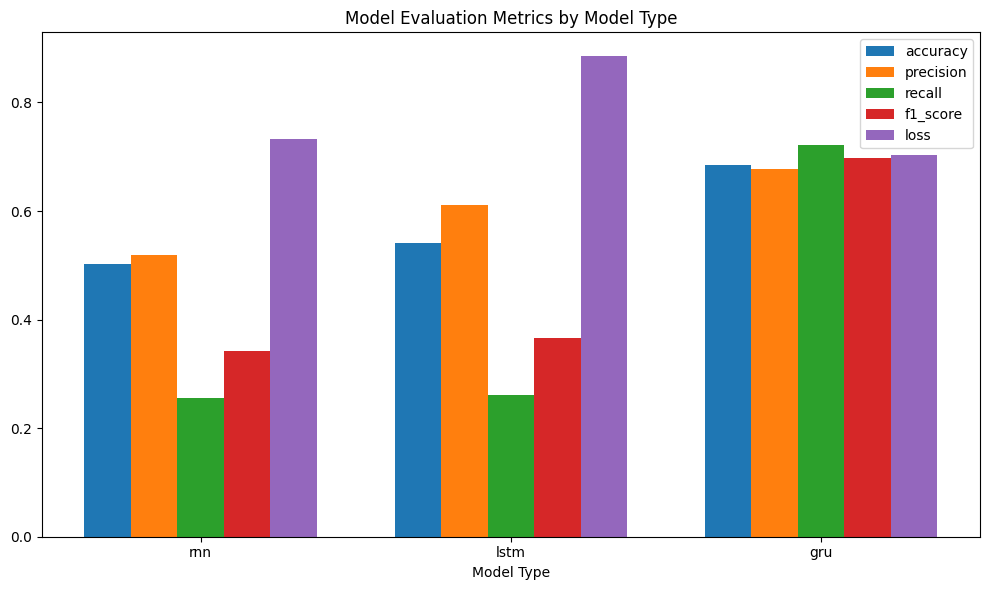

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame(results).T
data.index.name = 'Model'
data.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))
width = 0.15

metrics = data.columns[1:]
x = np.arange(len(data['Model']))
for i, metric in enumerate(metrics):
    ax.bar(x + i * width, data[metric], width, label=metric)

ax.set_xlabel('Model Type')
ax.set_title('Model Evaluation Metrics by Model Type')
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(data['Model'])
ax.legend()

fig.tight_layout()
plt.show()


## Conclusion

Congratulations on completing this comprehensive lab on Recurrent Neural Networks (RNNs) for sentiment analysis using the IMDB dataset! Throughout this exercise, you've successfully:

1. Loaded and preprocessed the IMDB dataset using the `datasets` library and PyTorch
2. Implemented a custom `IMDBDataset` class for efficient data handling
3. Designed and implemented a flexible `TextClassifier` model supporting three RNN architectures:
   - Simple RNN
   - Long Short-Term Memory (LSTM)
   - Gated Recurrent Unit (GRU)
4. Set up the training process with CrossEntropyLoss and Adam optimizer
5. Trained and evaluated each RNN architecture on the IMDB dataset
6. Evaluated the models' performance using various metrics:
   - Accuracy
   - Precision
   - Recall
   - F1 Score
   - Loss
7. Visualized the results using a grouped bar chart to compare model performances

Key takeaways from this lab:

- Understanding the structure and implementation of different RNN architectures in PyTorch
- The importance of proper data preprocessing and tokenization for NLP tasks
- The process of training and evaluating multiple model architectures on the same dataset
- The significance of various evaluation metrics in assessing model performance for sentiment analysis
- The value of visualizations in comparing the performance of different model architectures

This lab has provided you with hands-on experience in building, training, and evaluating RNN-based models for text classification. You've gained insights into the strengths and weaknesses of different RNN architectures and their application to sentiment analysis. These skills form a solid foundation for tackling more complex natural language processing tasks and understanding advanced sequence modeling techniques.